In [1]:
#
# MNIST
#
# @author becxer
# @email becxer87@gmail.com
# @reference https://github.com/sjchoi86/Tensorflow-101
#

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  

print ("packages are loaded")

packages are loaded


In [2]:
# Get MNIST data set from tensorflow
from tensorflow.examples.tutorials.mnist import input_data
mnist_set = input_data.read_data_sets('images/MNIST/', one_hot = True)

# One hot coding is ...
# 0 = (1,0,0,0,0,0,0,0,0,0)
# 1 = (0,1,0,0,0,0,0,0,0,0)
# 2 = (0,0,1,0,0,0,0,0,0,0)
# 3 = (0,0,0,1,0,0,0,0,0,0)

Extracting images/MNIST/train-images-idx3-ubyte.gz
Extracting images/MNIST/train-labels-idx1-ubyte.gz
Extracting images/MNIST/t10k-images-idx3-ubyte.gz
Extracting images/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
# Size of MNIST data set
print ("type(mnist_set) : %s" % (type(mnist_set)))
print ("len(mnist_set.train) : %s" % (mnist_set.train.num_examples))
print ("len(mnist_set.test) : %s" % (mnist_set.test.num_examples))

type(mnist_set) : <class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
len(mnist_set.train) : 55000
len(mnist_set.test) : 10000


In [4]:
# Shape of MNIST data set
train_img = mnist_set.train.images
train_label = mnist_set.train.labels
test_img = mnist_set.test.images
test_label = mnist_set.test.labels

print ("type(train_img) : %s" % type(train_img) )
print ("train_img.shape : %s" % str(train_img.shape))
print ("train_label.shape : %s" % str(train_label.shape))

type(train_img) : <type 'numpy.ndarray'>
train_img.shape : (55000, 784)
train_label.shape : (55000, 10)


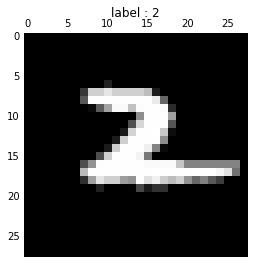

In [5]:
# Plot MNIST image
rand_idx = np.random.randint(train_img.shape[0], size = 1)

rand_img = np.reshape(train_img[rand_idx,:],(28,28))
rand_label = np.argmax(train_label[rand_idx,:])

plt.matshow(rand_img, cmap=plt.get_cmap('gray'))
plt.title("label : " + str(rand_label))

In [6]:
# Convert Image rows to array image
import numpy

def scale_to_unit_interval(ndar, eps=1e-8):
    """ Scales all values in the ndarray ndar to be between 0 and 1 """
    ndar = ndar.copy()
    ndar -= ndar.min()
    ndar *= 1.0 / (ndar.max() + eps)
    return ndar


def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                       scale_rows_to_unit_interval=True,
                       output_pixel_vals=True):
    """
    Transform an array with one flattened image per row, into an array in
    which images are reshaped and layed out like tiles on a floor.
    This function is useful for visualizing datasets whose rows are images,
    and also columns of matrices for transforming those rows
    (such as the first layer of a neural net).
    :type X: a 2-D ndarray or a tuple of 4 channels, elements of which can
    be 2-D ndarrays or None;
    :param X: a 2-D array in which every row is a flattened image.
    :type img_shape: tuple; (height, width)
    :param img_shape: the original shape of each image
    :type tile_shape: tuple; (rows, cols)
    :param tile_shape: the number of images to tile (rows, cols)
    :param output_pixel_vals: if output should be pixel values (i.e. int8
    values) or floats
    :param scale_rows_to_unit_interval: if the values need to be scaled before
    being plotted to [0,1] or not
    :returns: array suitable for viewing as an image.
    (See:`Image.fromarray`.)
    :rtype: a 2-d array with same dtype as X.
    """

    assert len(img_shape) == 2
    assert len(tile_shape) == 2
    assert len(tile_spacing) == 2

    # The expression below can be re-written in a more C style as
    # follows :
    #
    # out_shape    = [0,0]
    # out_shape[0] = (img_shape[0]+tile_spacing[0])*tile_shape[0] -
    #                tile_spacing[0]
    # out_shape[1] = (img_shape[1]+tile_spacing[1])*tile_shape[1] -
    #                tile_spacing[1]
    out_shape = [
        (ishp + tsp) * tshp - tsp
        for ishp, tshp, tsp in zip(img_shape, tile_shape, tile_spacing)
    ]

    if isinstance(X, tuple):
        assert len(X) == 4
        # Create an output numpy ndarray to store the image
        if output_pixel_vals:
            out_array = numpy.zeros((out_shape[0], out_shape[1], 4),
                                    dtype='uint8')
        else:
            out_array = numpy.zeros((out_shape[0], out_shape[1], 4),
                                    dtype=X.dtype)

        #colors default to 0, alpha defaults to 1 (opaque)
        if output_pixel_vals:
            channel_defaults = [0, 0, 0, 255]
        else:
            channel_defaults = [0., 0., 0., 1.]

        for i in range(4):
            if X[i] is None:
                # if channel is None, fill it with zeros of the correct
                # dtype
                dt = out_array.dtype
                if output_pixel_vals:
                    dt = 'uint8'
                out_array[:, :, i] = numpy.zeros(
                    out_shape,
                    dtype=dt
                ) + channel_defaults[i]
            else:
                # use a recurrent call to compute the channel and store it
                # in the output
                out_array[:, :, i] = tile_raster_images(
                    X[i], img_shape, tile_shape, tile_spacing,
                    scale_rows_to_unit_interval, output_pixel_vals)
        return out_array

    else:
        # if we are dealing with only one channel
        H, W = img_shape
        Hs, Ws = tile_spacing

        # generate a matrix to store the output
        dt = X.dtype
        if output_pixel_vals:
            dt = 'uint8'
        out_array = numpy.zeros(out_shape, dtype=dt)

        for tile_row in range(tile_shape[0]):
            for tile_col in range(tile_shape[1]):
                if tile_row * tile_shape[1] + tile_col < X.shape[0]:
                    this_x = X[tile_row * tile_shape[1] + tile_col]
                    if scale_rows_to_unit_interval:
                        # if we should scale values to be between 0 and 1
                        # do this by calling the `scale_to_unit_interval`
                        # function
                        this_img = scale_to_unit_interval(
                            this_x.reshape(img_shape))
                    else:
                        this_img = this_x.reshape(img_shape)
                    # add the slice to the corresponding position in the
                    # output array
                    c = 1
                    if output_pixel_vals:
                        c = 255
                    out_array[
                        tile_row * (H + Hs): tile_row * (H + Hs) + H,
                        tile_col * (W + Ws): tile_col * (W + Ws) + W
                    ] = this_img * c
        return out_array

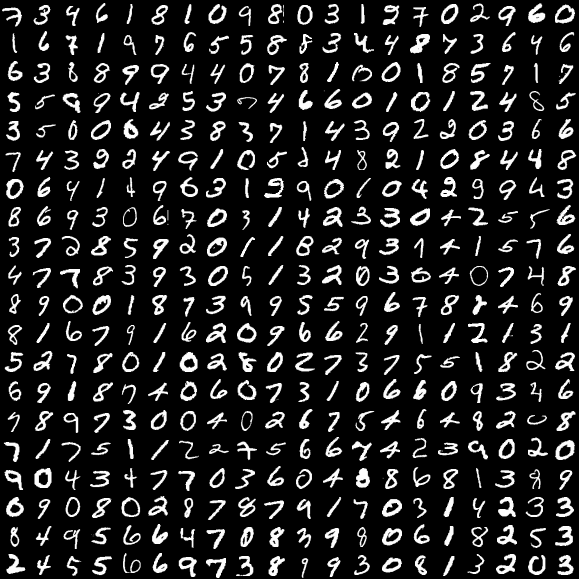

In [7]:
import PIL as pil
array_img = tile_raster_images( X = train_img, img_shape=(28, 28), tile_shape=(20, 20),tile_spacing=(1, 1))
pil.Image.fromarray(array_img)